# LOGISTIC REGRESSION FOR LIVER DISEASE DATA

In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler,  LabelEncoder
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
import statsmodels.api as sm

### Reading and displaying the file

In [3]:
file = pd.read_csv('indian liver Patient.csv')
file

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,is_patient
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,2
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,1


#### The column name 'is_patient ' has a space at the end. We change it to 'is_patient' for convenience.

In [4]:
# Changing the column name
file.rename(columns = {'is_patient ':'is_patient'}, inplace = True)

### Dealing with null values

In [5]:
# Number of null values in each column
file.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
is_patient                    0
dtype: int64

#### There are 4 null values in the 'Albumin_and_Globulin_Ratio' column.
As it is a small number, we can remove those rows.

In [6]:
# Removing the rows with null values
file = file[file['Albumin_and_Globulin_Ratio'].notnull()]

In [7]:
# Confirming that the data has been cleaned of null values
file.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
is_patient                    0
dtype: int64

#### There are no more null values.

## Looking at how the data is divided

<AxesSubplot:xlabel='is_patient', ylabel='count'>

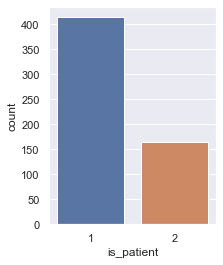

In [8]:
# Plotting the number of patients and non-patients in the dataset
sns.set(rc = {'figure.figsize':(3,4)})
sns.countplot(data=file, x = 'is_patient', label='Count')

#### In an imbalanced dataset, the target class has an uneven distribution of observations. Here, the target class is is-patient. The number of patients is much higher than the number of non-patients.
#### The data is imbalanced.
#### The f-1 performance measure is the most suitable in this situation.

## The relation between gender and the likelihood of liver disease

### Getting the ratio of patients to non-patients for each gender

In [9]:
print('The ratio of female patients to total females is',len(file[file['Gender']=='Female'][file['is_patient']==1])/len(file[file['Gender']=='Female']))
print('The ratio of male patients to total males is',len(file[file['Gender']=='Male'][file['is_patient']==1])/len(file[file['Gender']=='Male']))

The ratio of female patients to total females is 0.65
The ratio of male patients to total males is 0.7357630979498861


### Plotting the ratio of patients to non-patients for each gender

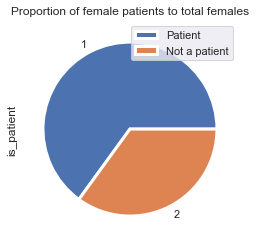

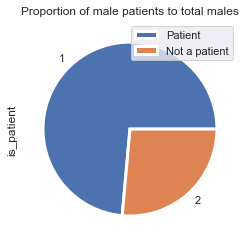

In [10]:
sns.set(rc = {'figure.figsize':(6,4)})
file[file['Gender']=='Female']['is_patient'].value_counts(normalize=True).plot.pie(wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.legend(['Patient','Not a patient'])
plt.title('Proportion of female patients to total females')
plt.show()

file[file['Gender']=='Male']['is_patient'].value_counts(normalize=True).plot.pie(wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.legend(['Patient','Not a patient'])
plt.title('Proportion of male patients to total males')
plt.show()

#### Males are more likely to get the disease.

## Effect of age on liver disease

### Showing the proportion of patients in different age brackets

In [11]:
f2 = pd.DataFrame()
f2['AgeBracket'] = [str(i*10+1)+'-'+str((i+1)*10) for i in range(9)]
f2['Diseasedproportion']=[ len(file[file['Age']>(i*10)][file['Age']<=(i+1)*10][file['is_patient']==1])  / len(file[file['Age']>(i*10)][file['Age']<=(i+1)*10]) for i in range(9)]
f2['CountsofPatients'] = [len(file[file['Age']>(i*10)][file['Age']<=(i+1)*10]) for i in range(9)]
f2

,AgeBracket,Diseasedproportion,CountsofPatients
0,1-10,0.428571,7
1,11-20,0.588235,34
2,21-30,0.561644,73
3,31-40,0.746032,126
4,41-50,0.744361,133
5,51-60,0.794393,107
6,61-70,0.641791,67
7,71-80,0.965517,29
8,81-90,0.333333,3


### Plotting the proportion of patients in different age brackets


<BarContainer object of 9 artists>

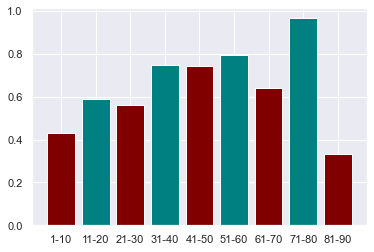

In [12]:
sns.set(rc = {'figure.figsize':(6,4)})
plt.bar(f2['AgeBracket'],f2['Diseasedproportion'],color=['maroon','teal'])

## Relationship between each biomarker and the likelihood of liver disease

Please enter the biomarker you want to plot: Age


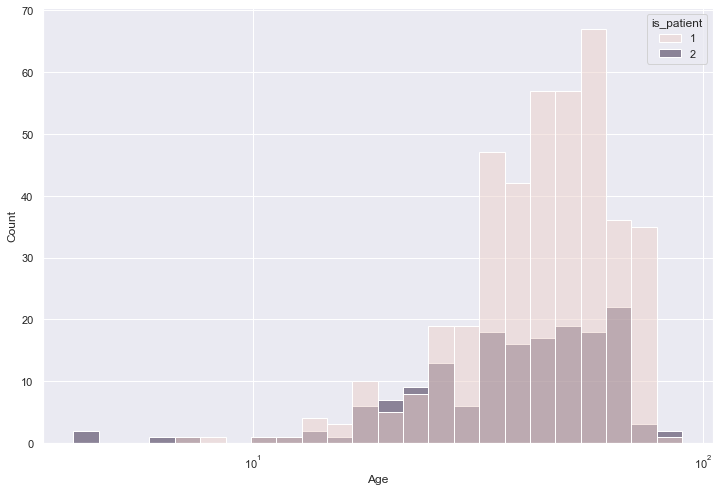

In [13]:
sns.set(rc = {'figure.figsize':(12,8)})
biomarker = str(input('Please enter the biomarker you want to plot: '))
def therel(biomarker):
    sns.histplot(data=file,x=biomarker, hue='is_patient', log_scale=True)
    plt.show()
therel(biomarker)

### Coverting the categorical variable to an indicator value

In [14]:
# Using the pd.get_dummies function
file = pd.get_dummies(file,drop_first = True)
file.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,is_patient,Gender_Male
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,1


### General heatmap with the correlation between the different biomarkers

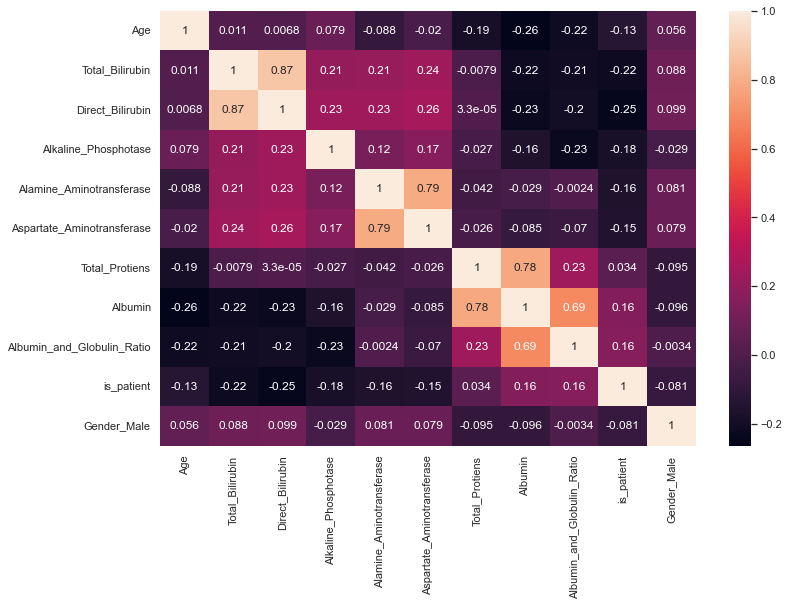

In [15]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(file.corr(), annot=True, cmap = 'rocket')
plt.show()

### Pairplot to visualise the correlation between markers

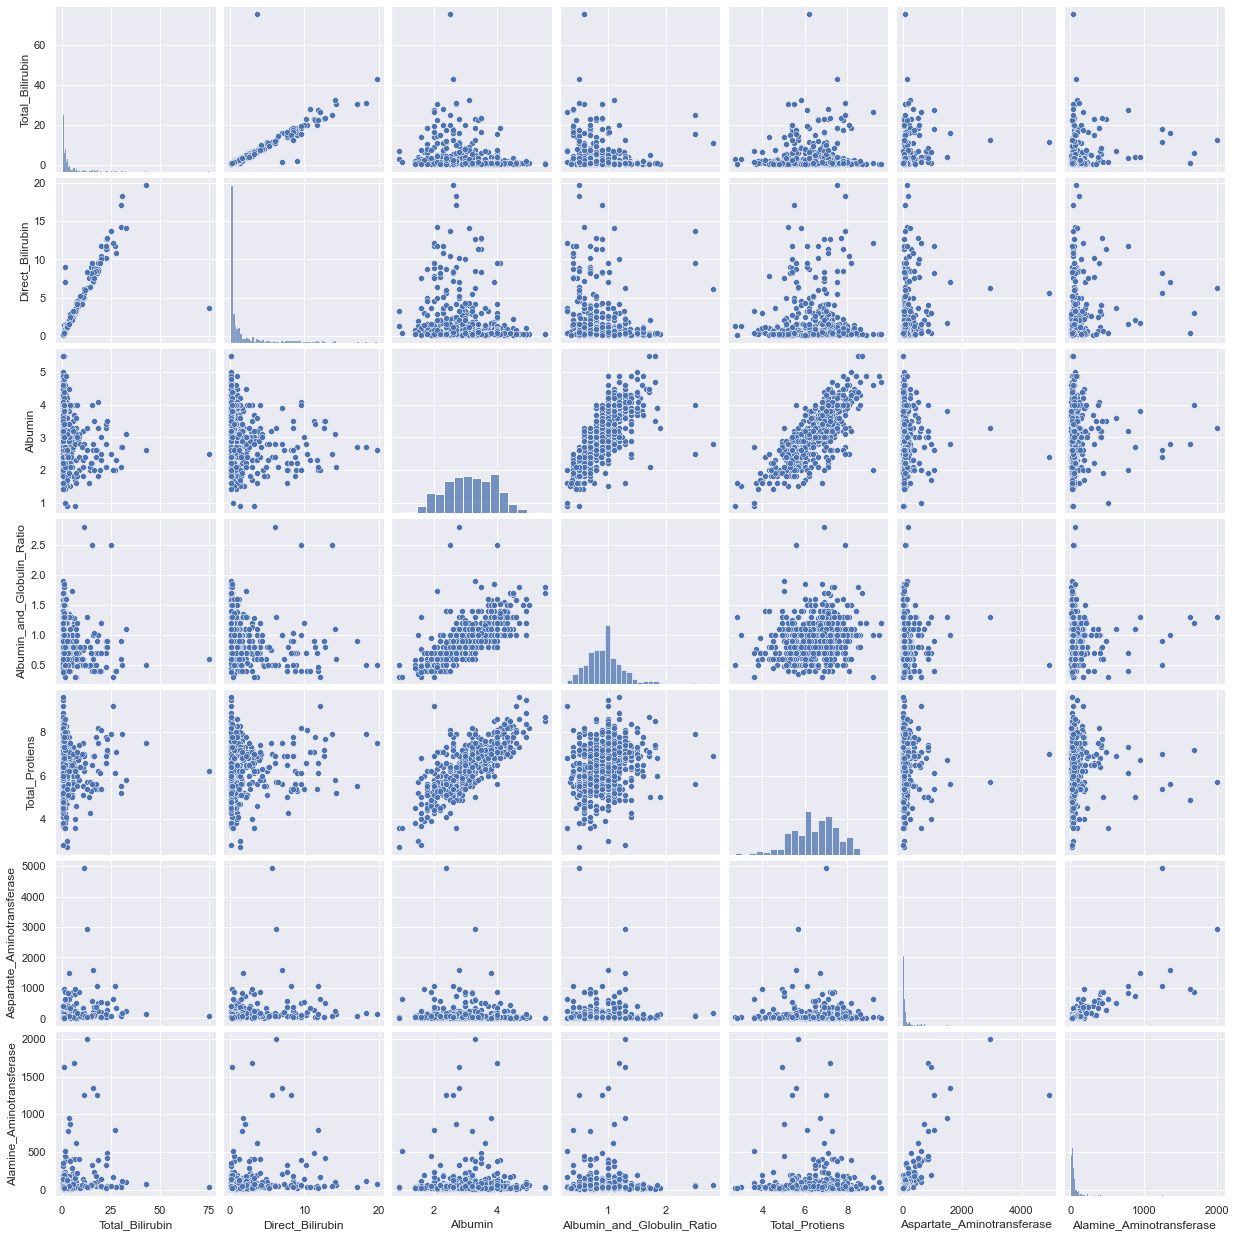

In [16]:
# Pair Plot. One shot for getting a quick distribution/correlation
sns.pairplot(file[['Total_Bilirubin','Direct_Bilirubin','Albumin','Albumin_and_Globulin_Ratio','Total_Protiens','Aspartate_Aminotransferase','Alamine_Aminotransferase']])

### Identifying the correlated variables

#### The following pairs of variables are correlated:
-Direct_Bilirubin and Total_Bilirubin
-Aspartate_Aminotransferase & Alamine_Aminotransferase
-Total_Protiens & Albumin
-Albumin_and_Globulin_Ratio and Albumin

#### We select one from each pair, and finally select the following variables:
-Total_Bilirubin <br>
-Alamine_Aminotransferase <br>
-Total_Protiens <br>
-Albumin_and_Globulin_Ratio <br>
-Alkaline Phosphotase

### Changing the is_patient column

In [17]:
# Changing all the values of 2 to 0
file['is_patient'] = np.where(file['is_patient'] == 2,0,1)

## LOGISTIC REGRESSION MODEL

In [18]:
# Importing modules
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [19]:
# The input variables as a separate dataset with only the selected variables
X = file.drop(['is_patient'], axis=1)
X = X[['Age', 'Direct_Bilirubin', 'Alkaline_Phosphotase','Alamine_Aminotransferase',
       'Total_Protiens', 'Albumin_and_Globulin_Ratio','Gender_Male']]
X.head()

,Age,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Total_Protiens,Albumin_and_Globulin_Ratio,Gender_Male
0,65,0.1,187,16,6.8,0.90,0
1,62,5.5,699,64,7.5,0.74,1
2,62,4.1,490,60,7.0,0.89,1
3,58,0.4,182,14,6.8,1.00,1
4,72,2.0,195,27,7.3,0.40,1


In [20]:
# The output variable as a separate dataset
y = file['is_patient']

### Splitting the data into test and train

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=62)

#### Looking at division after the split

In [22]:
print("Train:",y_train.value_counts(normalize = True))
print("Test:",y_test.value_counts(normalize = True))

Train: 1    0.720988
0    0.279012
Name: is_patient, dtype: float64
Test: 1    0.701149
0    0.298851
Name: is_patient, dtype: float64


### Model

In [23]:
logreg = LogisticRegression()

# Training the model
logreg.fit(X_train, y_train)

# Predicting the output
log_predicted= logreg.predict(X_test)

# Printing the coefficients
print("The independent variables are \n",X_train.columns)
print('The coefficients are \n', logreg.coef_)
print('The intercept is \n', logreg.intercept_)

The independent variables are 
 Index(['Age', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Total_Protiens',
       'Albumin_and_Globulin_Ratio', 'Gender_Male'],
      dtype='object')
The coefficients are 
 [[ 0.02359138  0.44626043  0.00098215  0.01409801 -0.05328957 -0.17080443
  -0.13815498]]
The intercept is 
 [-0.75115054]


#### Data frame showing the predicted coefficients for each independent variable:

In [24]:
cf_file = pd.DataFrame()
cf_file['Variable'] = X.columns
cf_file['Coefficient'] = logreg.coef_[0]

In [25]:
cf_file

,Variable,Coefficient
0,Age,0.023591
1,Direct_Bilirubin,0.446260
2,Alkaline_Phosphotase,0.000982
3,Alamine_Aminotransferase,0.014098
4,Total_Protiens,-0.053290
5,Albumin_and_Globulin_Ratio,-0.170804
6,Gender_Male,-0.138155


### Evaluating the model

#### Training set

The accuracy score is:  0.7432098765432099 

The confusion matrix is: 
 [[ 29  84]
 [ 20 272]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.59      0.26      0.36       113
           1       0.76      0.93      0.84       292

    accuracy                           0.74       405
   macro avg       0.68      0.59      0.60       405
weighted avg       0.72      0.74      0.71       405



<AxesSubplot:>

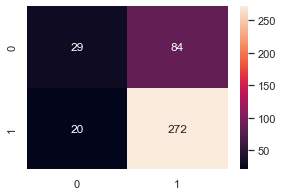

In [26]:
# predicting the output and showing the confusion matrix
predicted_train = logreg.predict(X_train)
Accuracy = accuracy_score(y_train, predicted_train)
print('The accuracy score is: ', Accuracy,'\n')
print('The confusion matrix is: \n',confusion_matrix(y_train, predicted_train),'\n')

# Showing the performance metrics
print('Classification report: \n',classification_report(y_train, predicted_train))

# Heatmap showing the confusion matrix values
sns.set(rc = {'figure.figsize':(4.5,3)})
sns.heatmap(confusion_matrix(y_train, predicted_train), annot = True, fmt="d")

#### Using ROC Curves

#### Train

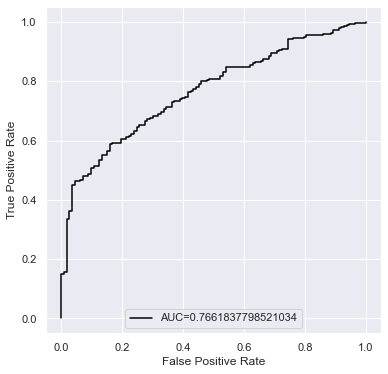

In [27]:
#define metrics
y_pred_prob = logreg.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train,  y_pred_prob) #fpr: false positive rate; tpr: true positive rate
auc = roc_auc_score(y_train, y_pred_prob)

#create ROC curve
sns.set(rc = {'figure.figsize':(6,6)})
plt.plot(fpr,tpr,label="AUC="+str(auc),color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()

#### Test

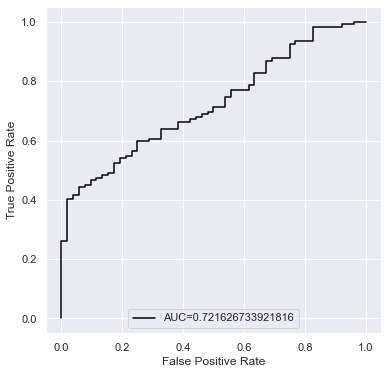

In [28]:
#define metrics
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba) #fpr: false positive rate; tpr: true positive rate
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc),color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()

#### Testing set

The accuracy score is:  0.7126436781609196 

The confusion matrix is: 
 [[ 10  42]
 [  8 114]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.19      0.29        52
           1       0.73      0.93      0.82       122

    accuracy                           0.71       174
   macro avg       0.64      0.56      0.55       174
weighted avg       0.68      0.71      0.66       174



<AxesSubplot:>

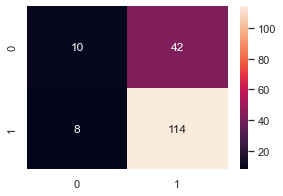

In [29]:
# predicting the output and showing the confusion matrix
Accuracy = accuracy_score(y_test, log_predicted)
print('The accuracy score is: ', Accuracy,'\n')
print('The confusion matrix is: \n',confusion_matrix(y_test, log_predicted),'\n')

# Showing the performance metrics
print('Classification report: \n',classification_report(y_test, log_predicted))

# Heatmap showing the confusion matrix values
sns.set(rc = {'figure.figsize':(4.5,3)})
sns.heatmap(confusion_matrix(y_test, log_predicted), annot = True, fmt="d")

### Performance metrics

-*Precision* : This metric measures how good the model is when the prediction is positive. <br>
-*Recall* : This metric measures how good the model is at correctly predicting positive classes. <br>
-*f-1 score* : This metric combines precision and recall.<br>

None of the metrics were good for the '0' values.<br>
For 'is_patient' = 1,<br>
the recall and f-1 scores for both the training and testing sets were decent, but the precision scores were only around 0.75.
The recall scores were the highest, with both the test and train scores being 0.93.

The most appropriate metric for this case is the f-1 score, as it is a good balance of both precision and recall metrics, and the dataset we have is imbalanced.

## Regularisation

### Lasso regularisation

In [30]:
logreg = LogisticRegression(penalty = 'l1', C=100000, solver = 'liblinear') #l1 represents Lasso regularisation

# Training the model
logreg.fit(X_train, y_train)

# Predicting the output
log_predicted= logreg.predict(X_test)

# Printing the coefficients
print("The independent variables are \n",X_train.columns)
print('The coefficients are \n', logreg.coef_)
print('The intercept is \n', logreg.intercept_)

The independent variables are 
 Index(['Age', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Total_Protiens',
       'Albumin_and_Globulin_Ratio', 'Gender_Male'],
      dtype='object')
The coefficients are 
 [[ 0.02409219  0.47834338  0.00104333  0.01396637 -0.05776576 -0.00670058
  -0.16221048]]
The intercept is 
 [-0.91727702]


#### Data frame showing the predicted coefficients for each independent variable:

In [31]:
cf_file = pd.DataFrame()
cf_file['Variable'] = X.columns
cf_file['Coefficient'] = logreg.coef_[0]
print(cf_file)

                     Variable  Coefficient
0                         Age     0.024092
1            Direct_Bilirubin     0.478343
2        Alkaline_Phosphotase     0.001043
3    Alamine_Aminotransferase     0.013966
4              Total_Protiens    -0.057766
5  Albumin_and_Globulin_Ratio    -0.006701
6                 Gender_Male    -0.162210


#### Evaluating the model

*Training set*

The accuracy score is:  0.745679012345679 

The confusion matrix is: 
 [[ 30  83]
 [ 20 272]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.60      0.27      0.37       113
           1       0.77      0.93      0.84       292

    accuracy                           0.75       405
   macro avg       0.68      0.60      0.60       405
weighted avg       0.72      0.75      0.71       405



<AxesSubplot:>

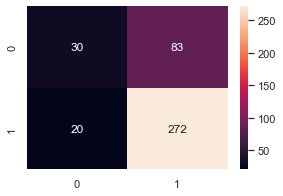

In [32]:
# predicting the output and showing the confusion matrix
predicted_train = logreg.predict(X_train)
Accuracy = accuracy_score(y_train, predicted_train)
print('The accuracy score is: ', Accuracy,'\n')
print('The confusion matrix is: \n',confusion_matrix(y_train, predicted_train),'\n')

# Showing the performance metrics
print('Classification report: \n',classification_report(y_train, predicted_train))

# Heatmap showing the confusion matrix values
sns.set(rc = {'figure.figsize':(4.5,3)})
sns.heatmap(confusion_matrix(y_train, predicted_train), annot = True, fmt="d")

#### Using ROC Curves

*Train*

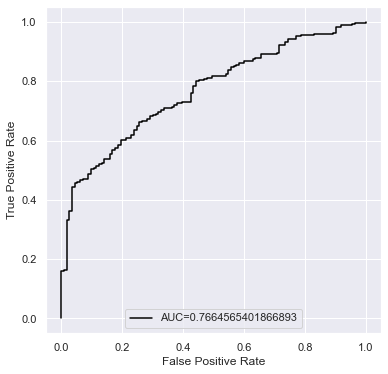

In [33]:
#define metrics
y_pred_prob = logreg.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train,  y_pred_prob) #fpr: false positive rate; tpr: true positive rate
auc = roc_auc_score(y_train, y_pred_prob)

#create ROC curve
sns.set(rc = {'figure.figsize':(6,6)})
plt.plot(fpr,tpr,label="AUC="+str(auc),color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()

*Test*

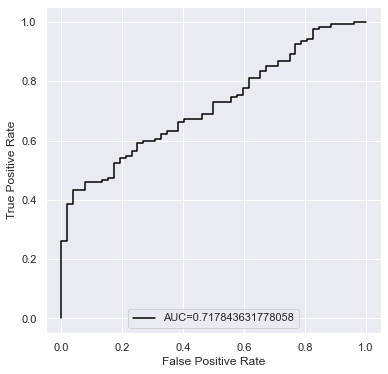

In [34]:
#define metrics
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba) #fpr: false positive rate; tpr: true positive rate
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc),color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()

*Testing set*

The accuracy score is:  0.7183908045977011 

The confusion matrix is: 
 [[ 11  41]
 [  8 114]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.58      0.21      0.31        52
           1       0.74      0.93      0.82       122

    accuracy                           0.72       174
   macro avg       0.66      0.57      0.57       174
weighted avg       0.69      0.72      0.67       174



<AxesSubplot:>

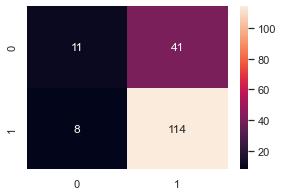

In [35]:
# predicting the output and showing the confusion matrix
Accuracy = accuracy_score(y_test, log_predicted)
print('The accuracy score is: ', Accuracy,'\n')
print('The confusion matrix is: \n',confusion_matrix(y_test, log_predicted),'\n')

# Showing the performance metrics
print('Classification report: \n',classification_report(y_test, log_predicted))

# Heatmap showing the confusion matrix values
sns.set(rc = {'figure.figsize':(4.5,3)})
sns.heatmap(confusion_matrix(y_test, log_predicted), annot = True, fmt="d")

### Ridge regularisation

In [36]:
logreg = LogisticRegression(penalty = 'l2', C=100000, solver = 'liblinear') #l1 represents Lasso regularisation

# Training the model
logreg.fit(X_train, y_train)

# Predicting the output
log_predicted= logreg.predict(X_test)

# Printing the coefficients
print("The independent variables are \n",X_train.columns)
print('The coefficients are \n', logreg.coef_)
print('The intercept is \n', logreg.intercept_)

The independent variables are 
 Index(['Age', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Total_Protiens',
       'Albumin_and_Globulin_Ratio', 'Gender_Male'],
      dtype='object')
The coefficients are 
 [[ 0.02207985  0.47054502  0.00094668  0.01357771 -0.09956622 -0.10301923
  -0.17391128]]
The intercept is 
 [-0.40331578]


#### Data frame showing the predicted coefficients for each independent variable:

In [37]:
cf_file = pd.DataFrame()
cf_file['Variable'] = X.columns
cf_file['Coefficient'] = logreg.coef_[0]
print(cf_file)

                     Variable  Coefficient
0                         Age     0.022080
1            Direct_Bilirubin     0.470545
2        Alkaline_Phosphotase     0.000947
3    Alamine_Aminotransferase     0.013578
4              Total_Protiens    -0.099566
5  Albumin_and_Globulin_Ratio    -0.103019
6                 Gender_Male    -0.173911


#### Evaluating the model

*Training set*

The accuracy score is:  0.7358024691358025 

The confusion matrix is: 
 [[ 27  86]
 [ 21 271]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.24      0.34       113
           1       0.76      0.93      0.84       292

    accuracy                           0.74       405
   macro avg       0.66      0.58      0.59       405
weighted avg       0.70      0.74      0.70       405



<AxesSubplot:>

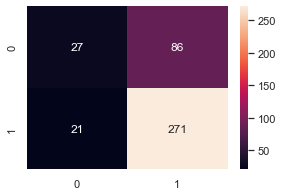

In [38]:
# predicting the output and showing the confusion matrix
predicted_train = logreg.predict(X_train)
Accuracy = accuracy_score(y_train, predicted_train)
print('The accuracy score is: ', Accuracy,'\n')
print('The confusion matrix is: \n',confusion_matrix(y_train, predicted_train),'\n')

# Showing the performance metrics
print('Classification report: \n',classification_report(y_train, predicted_train))

# Heatmap showing the confusion matrix values
sns.set(rc = {'figure.figsize':(4.5,3)})
sns.heatmap(confusion_matrix(y_train, predicted_train), annot = True, fmt="d")

#### Using ROC Curves

*Train*

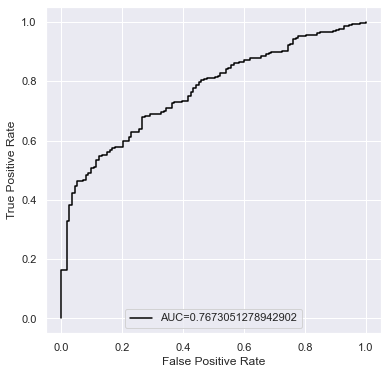

In [39]:
#define metrics
y_pred_prob = logreg.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train,  y_pred_prob) #fpr: false positive rate; tpr: true positive rate
auc = roc_auc_score(y_train, y_pred_prob)

#create ROC curve
sns.set(rc = {'figure.figsize':(6,6)})
plt.plot(fpr,tpr,label="AUC="+str(auc),color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()

*Test*

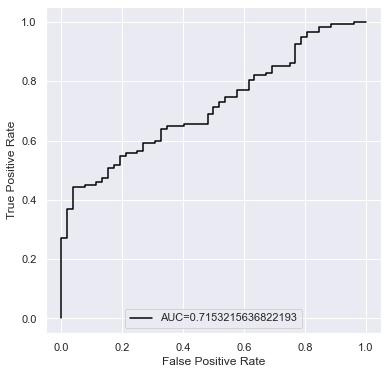

In [40]:
#define metrics
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba) #fpr: false positive rate; tpr: true positive rate
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc),color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()

*Testing set*

The accuracy score is:  0.7298850574712644 

The confusion matrix is: 
 [[ 10  42]
 [  5 117]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.19      0.30        52
           1       0.74      0.96      0.83       122

    accuracy                           0.73       174
   macro avg       0.70      0.58      0.57       174
weighted avg       0.72      0.73      0.67       174



<AxesSubplot:>

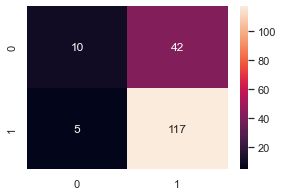

In [41]:
# predicting the output and showing the confusion matrix
Accuracy = accuracy_score(y_test, log_predicted)
print('The accuracy score is: ', Accuracy,'\n')
print('The confusion matrix is: \n',confusion_matrix(y_test, log_predicted),'\n')

# Showing the performance metrics
print('Classification report: \n',classification_report(y_test, log_predicted))

# Heatmap showing the confusion matrix values
sns.set(rc = {'figure.figsize':(4.5,3)})
sns.heatmap(confusion_matrix(y_test, log_predicted), annot = True, fmt="d")

#### The performance metrics did not change much after either of the regularisations.
#### The accuracy was worsened after regularisation, but only by a very small amount. This could just have been because of the particular random split, and it is not significant.

# LINEAR REGRESSION TO PREDICT ALAMINE AMINOTRASFERASE VALUES

In [42]:
# The input variables as a separate dataset with only the selected variables
X2 = file.drop(['Alamine_Aminotransferase'], axis=1)
X2 = X2[['Age', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Total_Protiens', 'Albumin_and_Globulin_Ratio','Gender_Male','is_patient']]
X2.head()

,Age,Direct_Bilirubin,Alkaline_Phosphotase,Total_Protiens,Albumin_and_Globulin_Ratio,Gender_Male,is_patient
0,65,0.1,187,6.8,0.90,0,1
1,62,5.5,699,7.5,0.74,1,1
2,62,4.1,490,7.0,0.89,1,1
3,58,0.4,182,6.8,1.00,1,1
4,72,2.0,195,7.3,0.40,1,1


In [43]:
# The output variable as a separate dataset
y2 = file['Alamine_Aminotransferase']

### Splitting the data into test and train

In [44]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=107)

### Model

In [45]:
LinReg = LinearRegression()
LinReg.fit(X2_train , y2_train)
accuracies = cross_val_score(estimator = LinReg, X = X2_train, y = y2_train, cv = 5,verbose = 1)
y2_pred = LinReg.predict(X2_test)
print('')
print('####### Linear Regression #######')
print('Score : %.4f' % LinReg.score(X2_test, y2_test))
print(accuracies)

mse = mean_squared_error(y2_test, y2_pred)
mae = mean_absolute_error(y2_test, y2_pred)
rmse = mean_squared_error(y2_test, y2_pred)**0.5
r2 = r2_score(y2_test, y2_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

print("Linear Regression Coefficients: \n")
print(LinReg.coef_)
R2_Scores=[]
R2_Scores.append(r2)


x2_train = X2_train
y2_train_2 = y2_train
x2_train_1 = sm.add_constant(x2_train)
model = sm.OLS(y2_train_2, x2_train_1)
results = model.fit()
print(results.summary())



####### Linear Regression #######
Score : -0.0317
[ 0.06301383  0.13265018  0.16487377 -0.01538924  0.0595849 ]

MSE    : 30322.09 
MAE    : 80.97 
RMSE   : 174.13 
R2     : -0.03 
Linear Regression Coefficients: 

[ -1.55552685  15.07506483   0.10025892 -17.14531668  26.43061663
  21.6101163   44.26486131]
                               OLS Regression Results                               
Dep. Variable:     Alamine_Aminotransferase   R-squared:                       0.126
Model:                                  OLS   Adj. R-squared:                  0.110
Method:                       Least Squares   F-statistic:                     8.150
Date:                      Mon, 29 Aug 2022   Prob (F-statistic):           2.77e-09
Time:                              18:02:21   Log-Likelihood:                -2667.7
No. Observations:                       405   AIC:                             5351.
Df Residuals:                           397   BIC:                             5383.
Df Model: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


#### The model produced an R2 value of -0.03, which means that the it is an extremely bad fit.
#### This shows that the alamine aminotransferase values are not a linear combination of the rest of the variables, and linear regression was not a good model for the prediction.